# Project Title
## Financial Metrics: Time Series Analysis and Insights Using NASDAQ API Data

## Business Problem

"The goal of this project is to understand how key financial indicators(KPIs) for NASDAQ-listed companies have evolved over time, helping to identify trends, patterns, and potential influencing factors in the market."

+ **Objective:-** Leverage the **NASDAQ API** to fetch financial data, **perform exploratory data analysis (EDA)**, and **conduct Time series analysis** to uncover trends and patterns in **key performance indicators (KPIs)** across **different companies** examining how these KPIs **change over time** and understanding the underlying factors driving these changes.This comprehensive analysis provided valuable insights into the financial health of companies, aiding stakeholders in making informed decisions and strategic plans.

+ **Challenges:**
    + **Data Complexity and Volume**
         + **Multidimensional Data:-** Financial data can be multidimensional, encompassing various companies, time periods, and financial indicators.                                         This requires a structured approach to manage and analyze effectively.
           
         + **Large Data Sets:-** Financial data can be voluminous, especially when dealing with long time periods or multiple companies.
     
    + **Data Cleaning and Preprocessing:**
         + **Missing Values:-** Handling incomplete or missing data points which can impact the accuracy of the analysis.
     
         + **Outliers:-** Identifying and managing anomalies or outliers that may distort trend analysis.
     
         + **Data Types:-** Ensuring that all data is in the correct format (e.g., date fields as datetime objects, numeric fields correctly typed).
    
    + **Data Aggregation** Choosing the right level of aggregation that balances detail and readability.

    + **Trend Identification and Analysis:**
         + **Identifying seasonal Patterns:-** Identifying specific seasonal trends in **specific quarters** due to seasonal factors, like reduced                                                     demand or production. Assessing seasonality consistency involving checking, whether these seasonal                                                      trends occur consistently every year, or if they are affected by other external factors. Recognizing                                                    these patterns helps businesses anticipate financial performance at different times of the year.
     
         + **Long-Term Trend Analysis:-** It refers to identifying sustained patterns of growth or decline in in key financial metrics performance,                                               over an extended period, typically **spanning multiple quarters or years**. It can be either cyclical or one-                                           time event. Cyclical Market Behavior refers to patterns in KPIs performance that repeat over regular                                                    intervals due to recurring factors in the economy, industry, or market.In contrast to cyclical trends, one-                                             time events are isolated occurrences that temporarily impact financial performance. 
         
    + **Handling Volatility and Anomalies**
        + **Understanding Volatility and Anomalies:-** Sudden financial shifts caused by global events like economic recessions, pandemics, or                                                                 geopolitical issues must be accounted for to prevent **skewed results**. Volatility refers to                                                           the degree of variation in financial metrics (e.g., stock prices, revenue, profit) over time.                                                           High volatility means larger swings in the data, while low volatility indicates more stability.
                                                       Volatility is short term or long term
                                                       Anomalies are data points or events that deviate significantly from the expected pattern or                                                             trend. These can be due to one-time events, data errors, or extraordinary circumstances.
                                                       Types of Anomalies:
                                                       Positive Anomalies: Unexpected spikes in financial metrics, such as a sharp increase in revenue                                                         due to the release of a highly successful product.
                                                       Negative Anomalies: Sudden drops in performance, such as a significant revenue decline due to a                                                         lawsuit or regulatory penalty.
                                                       Structural Breaks: Large shifts in data caused by significant events like mergers, acquisitions,                                                        or regulatory changes that fundamentally alter the company’s operations.
                                                       Anomalies, also known as outliers, refer to data points or events that deviate significantly                                                            from the expected pattern or behavior in a dataset. Unlike volatility, anomalies are unexpected                                                         and often indicate something unusual or incorrect in the data.
                                                       Anomalies are irregularities or outliers that stand out from the rest of the dataset. They often                                                        signal one-time events, errors, or extraordinary circumstances that deviate from normal patterns.
                                                       Volatility is an inherent characteristic of financial time series, reflecting regular ups and                                                           downs in stock prices, revenue, profit, or other metrics.
                                                       It represents the natural variability or uncertainty in a dataset, often measured by how much                                                           values deviate from a central trend or average.       
    
    + **Visualization and Interpretation:**
       + **Communicating Complexities** Creating time series plots for multiple companies and financial indicators without overwhelming the viewer,                                             ensuring clarity in identifying trends, peaks, and troughs.Tailoring visualizations to the audience, with                                               simplified visuals for non-experts and more granular data presentations for finance professionals.
         
             

+ **Brief API description:-** The [NASDAQ Data Link](https://docs.data.nasdaq.com/docs/in-depth-usage-1) API provides a gateway to a wide range of financial data sets, including **comprehensive financial metrics on various companies**. 

## Libraries

In [ ]:
import requests
import pandas as pd
import numpy as np


## Data Collection

### Fetch Data from Nasdaq API

In [2]:
import requests
import pandas as pd

#To determine the appropriate API endpoint and the parameters needed to query the financial data, refer to the Nasdaq Data Link API documentation for guidance on constructing your query.         

# Function to fetch data from the API
def fetch_data(url, API_key, cursor=None, limit=1000):
    params = {"qopts.per_page": limit,
             "api_key" : API_key
             }
    if cursor:
        params['qopts.cursor_id'] = cursor

    response = requests.get(url, params=params)
    response.raise_for_status()  # Raise an exception for HTTP errors
    return response.json()


## Data Integration into Dataframe

In [19]:
# Base URL for the API
base_url = "https://data.nasdaq.com/api/v3/datatables/MER/F1.json"
limit = 1000  # Number of items per page
API_Key = "9LVNHxksgJPUXGKbCDXw" #The Nasdaq Data Link API requires an API key for access.

# Initialize an empty DataFrame to store the results
combined_df = pd.DataFrame()

# Initialize cursor to start the first page
cursor = None

while True:
    # Fetch data from the API
    response_data = fetch_data(base_url, API_Key, cursor, limit)
    
    # Extract the datatable, columns, and data
    datatable = response_data.get('datatable', {})
    data = datatable.get('data', [])
    columns_info = datatable.get('columns', [])
    
    # Extract column names
    column_names = [col['name'] for col in columns_info]
    
    # Convert data to a DataFrame
    if data:
        page_df = pd.DataFrame(data, columns = column_names)
        
        # Append the DataFrame for the current page to the combined DataFrame
        combined_df = pd.concat([combined_df, page_df], ignore_index=True)
    
    # Extract the next cursor, if it exists
    next_cursor = response_data.get('meta', {}).get('next_cursor_id')
    
    # Break the loop if there are no more pages
    if not next_cursor:
        break
    
    # Update cursor for the next page
    cursor = next_cursor

In [95]:
# Save the DataFrame to a CSV file
combined_df.to_csv("raw_financial_data.csv", index=False)
# When you're working with data in memory (e.g., within a Python session or a Jupyter notebook), that data will be lost once the session ends or the notebook is closed. 
#Saving the DataFrame to a CSV file ensures that the data is stored persistently on disk and can be accessed later.

# Print the DataFrame to confirm
print("Data saved to raw_financial_data.csv")
# Load the CSV file into a DataFrame
df = pd.read_csv("raw_financial_data.csv")
# Print the number of rows and columns
num_rows, num_columns = df.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")


Data saved to raw_financial_data.csv
Number of rows: 30769
Number of columns: 32


## Data Preparation

### Data Cleaning & Preprocessing

+ **Remove Duplicates:** 
+ **Handle Missing Values:**
+ **Convert Data Types:** 
+ **Remove Irrelevant Information:**
+ **Handling Outliers**

####  Removing leading/trailing spaces and Standardized DataFrame Column Names

In [96]:
import pandas as pd
import numpy as np

# Removing leading/trailing spaces and Standardized DataFrame Column Names 
df.columns = df.columns.str.strip().str.title()
df.columns

Index(['Compnumber', 'Reportid', 'Mapcode', 'Amount', 'Reportdate',
       'Reporttype', 'Auditorstatus', 'Currency', 'Consolidated', 'Longname',
       'Shortname', 'Status', 'Countrycode', 'Region', 'Cik', 'Mic', 'Ticker',
       'Exchange', 'Address1', 'Address2', 'Address3', 'Address4', 'City',
       'Statecode', 'Country', 'Zipcode', 'Phonenumber', 'Faxnumber',
       'Website', 'Fye', 'Indicator', 'Statement'],
      dtype='object')

#### Removed Duplicate Entries Rows to Ensure Data Quality

In [97]:
# Remove duplicates
df.drop_duplicates(inplace=True) # Removed Duplicate Entries Rows to Ensure Data Quality
df.shape


(30769, 32)

#### Handling Missing values

In [98]:
print(df.isnull().sum())
# Count the total number of cities in each country (including missing)
total_cities_per_country = df.groupby('Country')['City'].count()

# Count the number of missing cities in each country
missing_cities_per_country = df[df['City'].isna()].groupby('Country').size()

# Combine the results into a single DataFrame
result = pd.DataFrame({
    'Total Cities': df.groupby('Country')['City'].count(),
    'Missing Cities': df[df['City'].isna()].groupby('Country').size()
}).fillna(0).astype(int)  # Fill NaNs with 0 and convert to integer

# Display the result
print("Number of cities (including missing) and missing cities in each country:")
print(result)

Compnumber           0
Reportid             0
Mapcode              0
Amount               0
Reportdate           0
Reporttype           0
Auditorstatus        2
Currency             0
Consolidated         0
Longname             0
Shortname            0
Status               0
Countrycode          0
Region               0
Cik                  0
Mic                  0
Ticker            2138
Exchange             0
Address1             0
Address2         15770
Address3         25766
Address4         30769
City              2440
Statecode        19242
Country              0
Zipcode           2916
Phonenumber          0
Faxnumber        14460
Website              0
Fye                  0
Indicator            0
Statement            0
dtype: int64
Number of cities (including missing) and missing cities in each country:
         Total Cities  Missing Cities
Country                              
AUS               456               0
BEL               781               0
BHS               898     

In [99]:
# Forward fill the 'Auditorstatus' column
df['Auditorstatus'] = df['Auditorstatus'].ffill()

# Identify countries where all cities are missing
all_missing_countries = df.groupby('Country')['City'].apply(lambda x: x.isna().all())

# Get the list of countries where all cities are missing
countries_to_remove = all_missing_countries[all_missing_countries].index

df = df[~df['Country'].isin(countries_to_remove)]



In [100]:
# Convert data types
# Convert 'reportdate' to datetime
df['Reportdate'] = pd.to_datetime(df['Reportdate'], errors='coerce') # Standardized Date Formats for Time Series Analysis

# Optimized Memory Usage by Converting Categorical Data
# Convert categorical columns to category type
categorical_columns = ['Reporttype', 'Auditorstatus', 'Currency', 'Consolidated', 'Status', 
                      'Country', 'Indicator', 'Statement']

for col in categorical_columns:
    df[col] = df[col].astype('category')



#### Streamlining Dataset

In [101]:
# Streamlined Dataset by Dropping Irrelevant Columns (to improve data relevance and focus on key variables for analysis.)
# Remove irrelevant or duplicate information
df.drop(columns=['Address1', 'Address2', 'Address3', 'Address4', 'Phonenumber', 'Faxnumber','Website', 'Statecode', 'Fye', 'Region', 'Cik', 'Mic', 'Ticker', 'Zipcode', 'Countrycode', 'Mapcode', 'Compnumber', 'Shortname' ], inplace=True) 


In [102]:
df = df.sort_values(by=['Longname', 'Reportdate'], ascending=[True, False])


In [103]:
# Mapped Country Codes to Full Names for Enhanced Readability
# Create a dictionary for mapping country codes to country names
country_dict = {
    'USA': 'United States',
    'GBR': 'United Kingdom',
    'CYM': 'Cayman Islands',
    'CAN': 'Canada',
    'KOR': 'South Korea',
    'ISR': 'Israel',
    'FIN': 'Finland',
    'JPN': 'Japan',
    'IND': 'India',
    'DNK': 'Denmark',
    'IRL': 'Ireland',
    'CHL': 'Chile',
    'ITA': 'Italy',
    'ESP': 'Spain',
    'BHS': 'Bahamas',
    'HKG': 'Hong Kong',
    'FRA': 'France',
    'DEU': 'Germany',
    'BEL': 'Belgium',
    'BMU': 'Bermuda',
    'CHE': 'Switzerland',
    'IDN': 'Indonesia',
    'AUS': 'Australia',
    'BRA': 'Brazil'
}
# Assuming 'df' is your DataFrame and 'country_code' is the column with country codes
df['Country'] = df['Country'].map(country_dict)




### Handling Outliers

+ **Identify Outliers**
   + **Visual Identification:** Use visualizations such as box plots and scatter plots to detect outliers
+ **Statistical Methods to Detect Outliers**
   + **Interquartile Range (IQR) Method**
+ **Handle Outliers**
   + **Remove Outliers**: For extreme outliers that are clearly erroneous, removing them from the dataset may be appropriate.
   + **Cap or Floor the Outliers**: Set outliers to a maximum or minimum value based on acceptable business limits (also known as winsorizing).
   + **Transform Data**: Use logarithmic or other transformations to reduce the impact of outliers on the analysis.

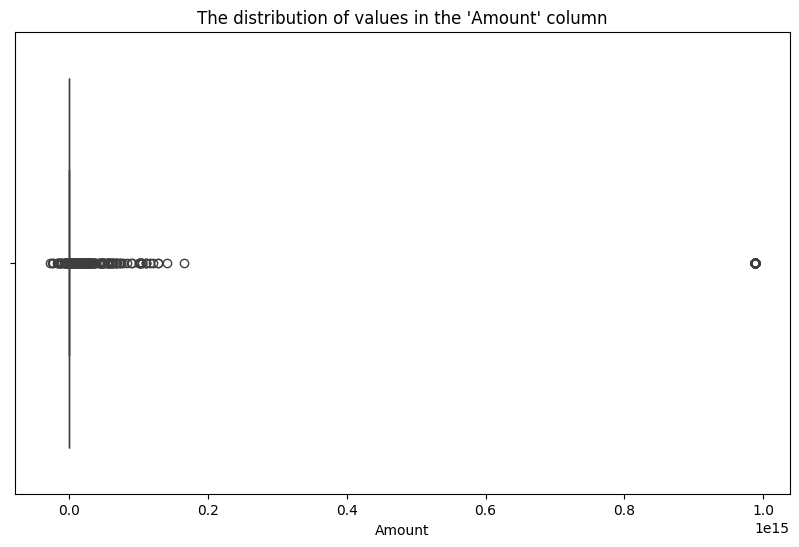

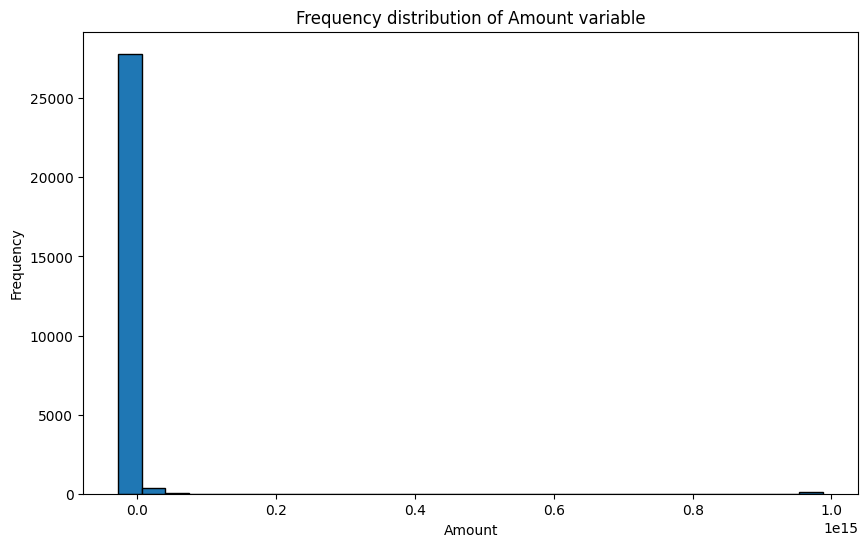

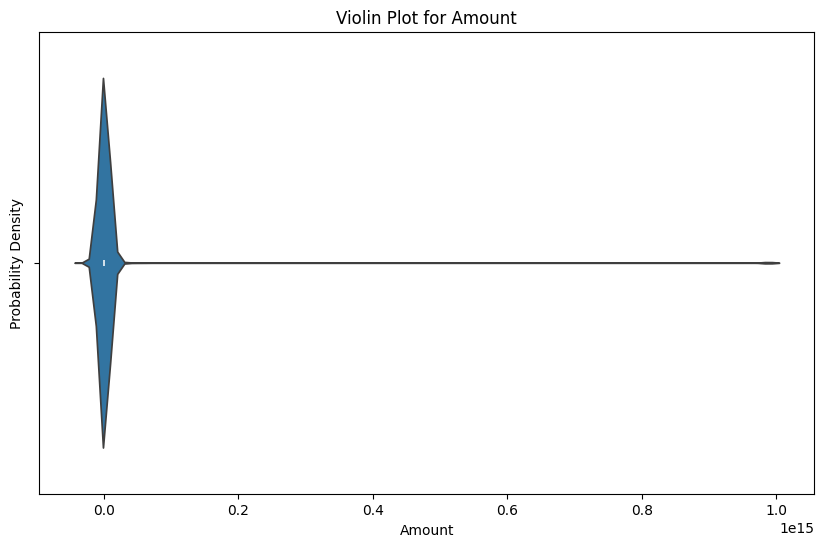

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of values in the 'Amount' column of the DataFrame df.
# Box Plot to visualize outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Amount'])
plt.title("The distribution of values in the 'Amount' column")
plt.show()

# Histogram for the 'amount' column
plt.figure(figsize=(10, 6))
plt.hist(df['Amount'], bins=30, edgecolor='black')
plt.title('Frequency distribution of Amount variable')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

# Violin plot for 'amount' column
plt.figure(figsize=(10, 6))
sns.violinplot(x=df['Amount'])
plt.title('Violin Plot for Amount')
plt.xlabel('Amount')
plt.ylabel('Probability Density')
plt.show()




In [105]:
# Calculate IQR
# Identified Outliers Using IQR Method
amount_data = df['Amount']
Q1 = amount_data.quantile(0.25)
Q3 = amount_data.quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = amount_data[(amount_data < lower_bound) | (amount_data > upper_bound)]
print(f"Number of outliers: {len(outliers)}") # Print Number of Outliers


Number of outliers: 5731


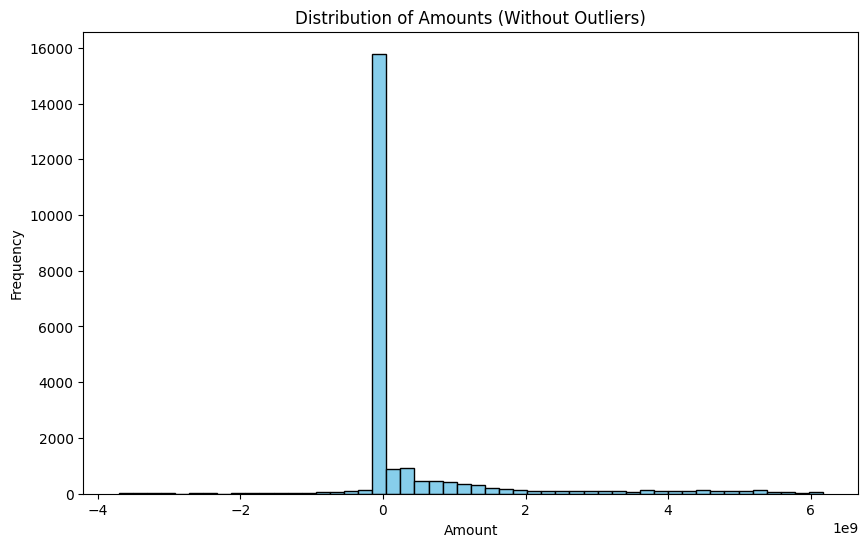

In [106]:
# Remove outliers
df = df[(df['Amount'] >= lower_bound) & (df['Amount'] <= upper_bound)]

# Plot histogram of data without outliers
plt.figure(figsize=(10, 6))
plt.hist(df['Amount'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Amounts (Without Outliers)')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()


## EDA

+ **Descriptive Statistics:** Compute summary statistics for numeric columns.
+ **Distribution Analysis:** Plot the distribution of key variables (e.g., financial amounts).
+ **Time Series Analysis:** Analyze and plot how financial metrics change over time.
+ **Correlation Analysis:** Examine relationships between numerical columns.
+ **Categorical Analysis:** Assess the distribution of categorical variables (e.g., indicators, statuses).

### Descriptive Statistics

In [107]:
# Drop any missing values in 'amount' column
amount_data = df['Amount'].dropna()

# Descriptive statistics
summary_stats = amount_data.describe()
print("Descriptive Statistics:")
print(summary_stats)

# Additional statistics
median_amount = amount_data.median()
variance_amount = amount_data.var()
print(f"Median of 'amount': {median_amount}")
print(f"Variance of 'amount': {variance_amount}")


Descriptive Statistics:
count    2.259800e+04
mean     4.508390e+08
std      1.215416e+09
min     -3.709000e+09
25%      1.130332e+00
50%      1.541644e+01
75%      1.931696e+08
max      6.172000e+09
Name: Amount, dtype: float64
Median of 'amount': 15.41644
Variance of 'amount': 1.4772370433068321e+18


### Categorical Variables Analysis 

#### Pie chart

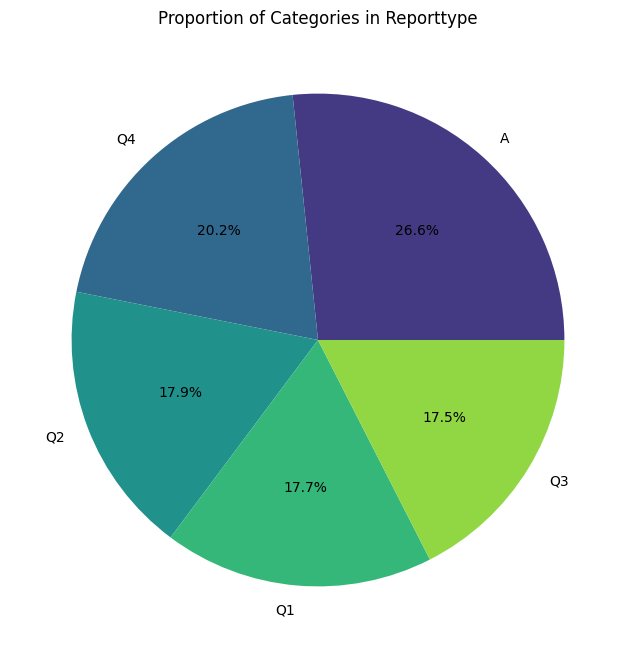

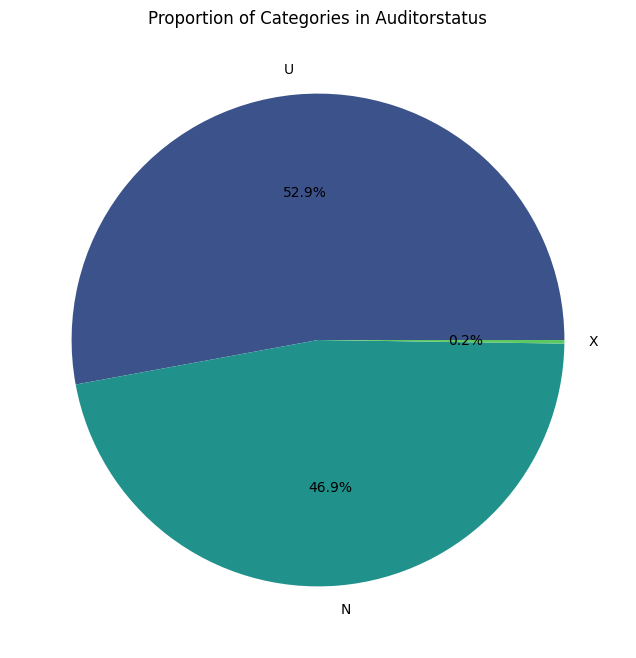

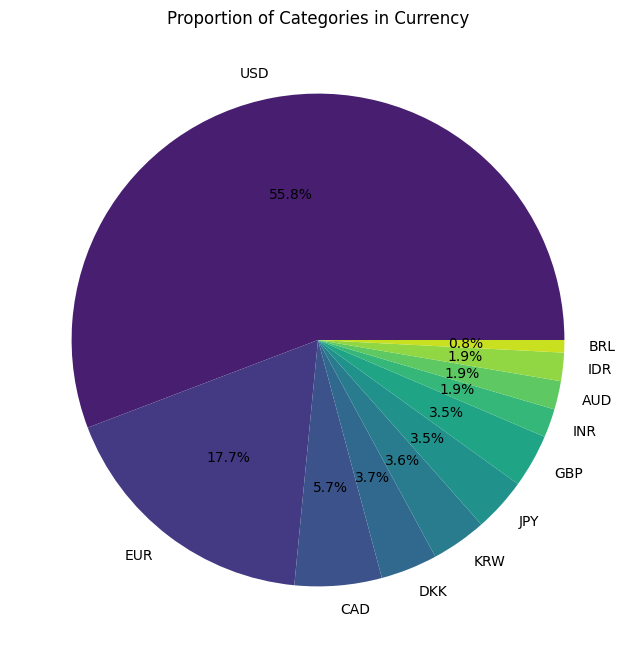

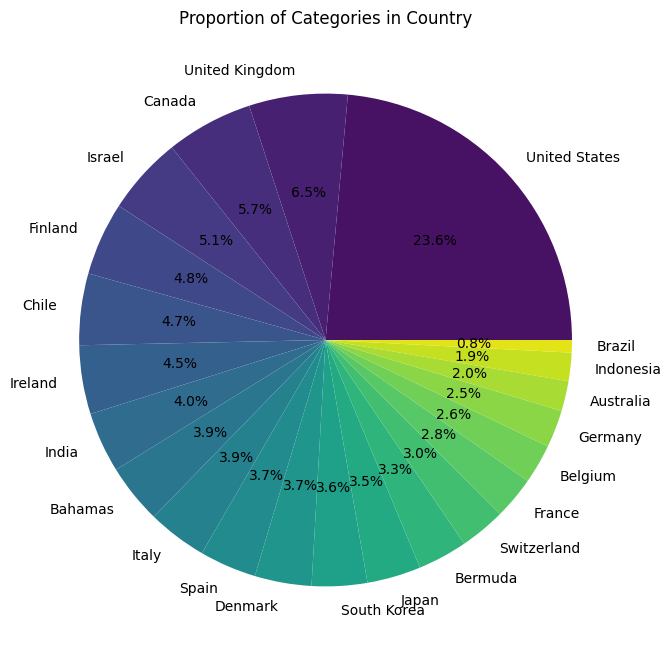

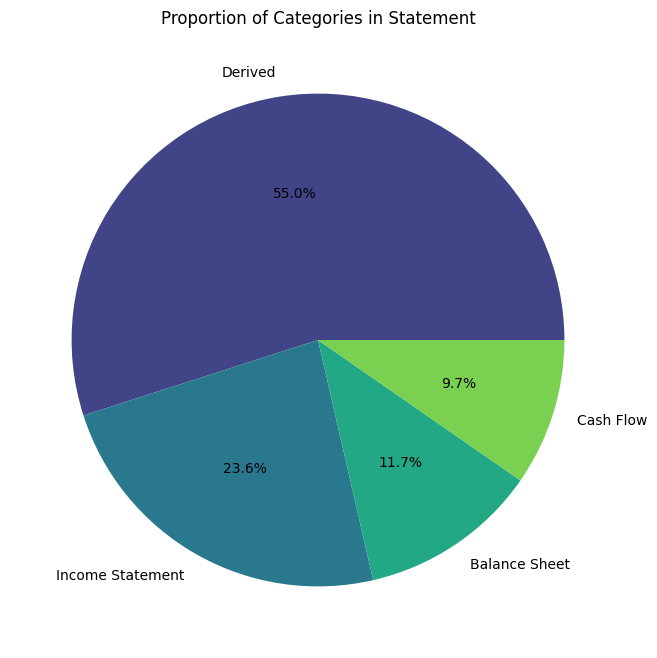

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

categories = ['Reporttype', 'Auditorstatus', 'Currency', 'Country', 'Statement']

# Plot pie charts for categorical variables
for col in categories:
    plt.figure(figsize=(8, 8))
    df[col].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('viridis', len(df[col].unique())))
    plt.title(f'Proportion of Categories in {col}')
    plt.ylabel('')
    plt.show()


#### Barplot

C:\Users\Sagarzzzz\AppData\Local\Temp\ipykernel_7120\2153491124.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Indicator', order=indicator_list, palette=color_map)


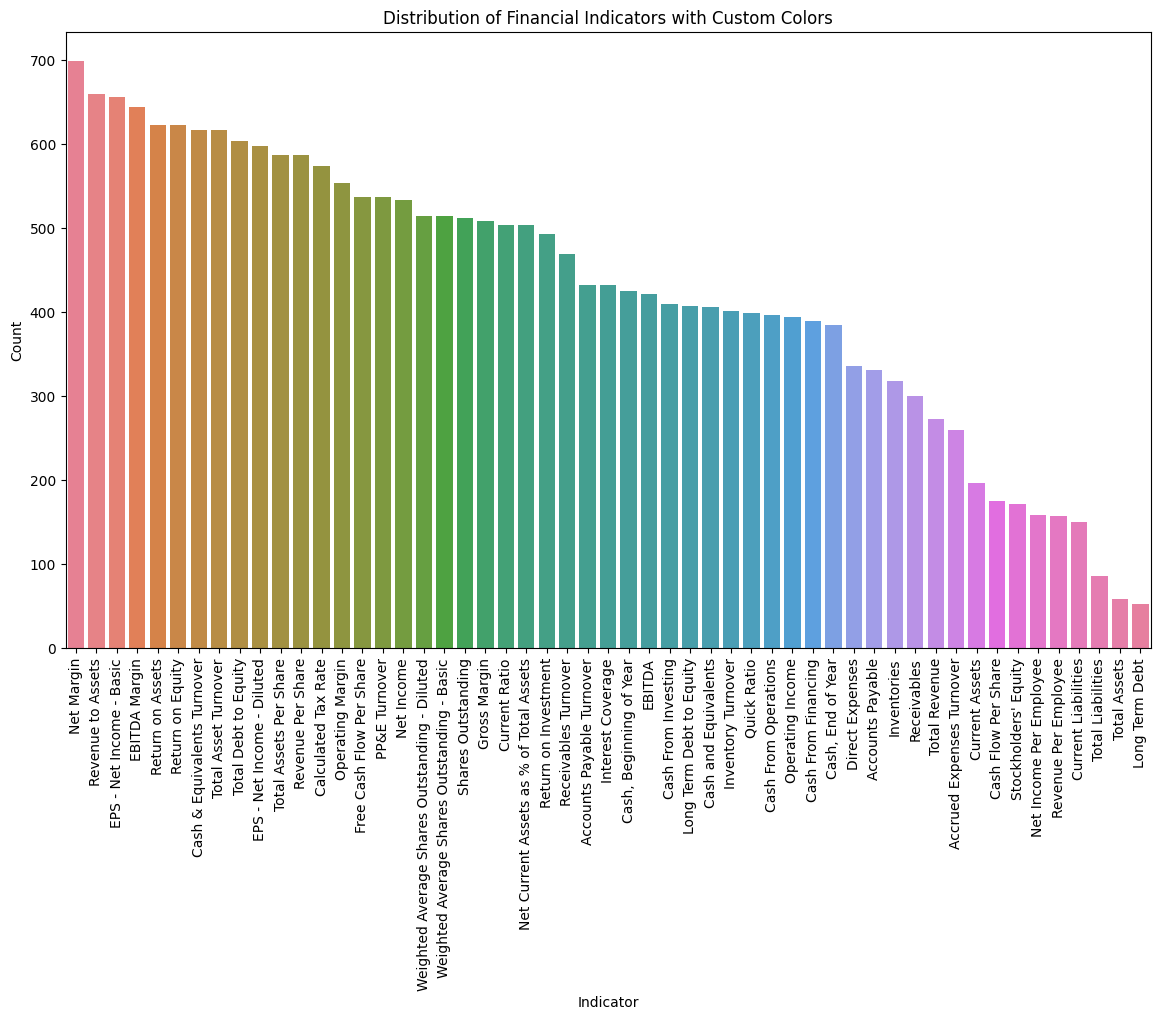

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate a color palette with 53 distinct colors
palette = sns.color_palette("husl", 53)

# Create a dictionary mapping each indicator to a color
indicator_list = df['Indicator'].value_counts().index
color_map = dict(zip(indicator_list, palette))

# Plot the count plot with custom colors
plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='Indicator', order=indicator_list, palette=color_map)
plt.xticks(rotation=90)  # Rotate labels for better readability
plt.title("Distribution of Financial Indicators with Custom Colors")
plt.xlabel("Indicator")
plt.ylabel("Count")
plt.show()


### Distribution Analysis(Numeric Variable(s))

+ Histogram with KDE:
    +  The sns.histplot() plots a histogram for the numeric variable along with the KDE (Kernel Density Estimation), which gives a smoothed line of the distribution.
    + Boxplot: The sns.boxplot() shows the distribution of data, highlighting the median, quartiles, and outliers for each numeric variable.


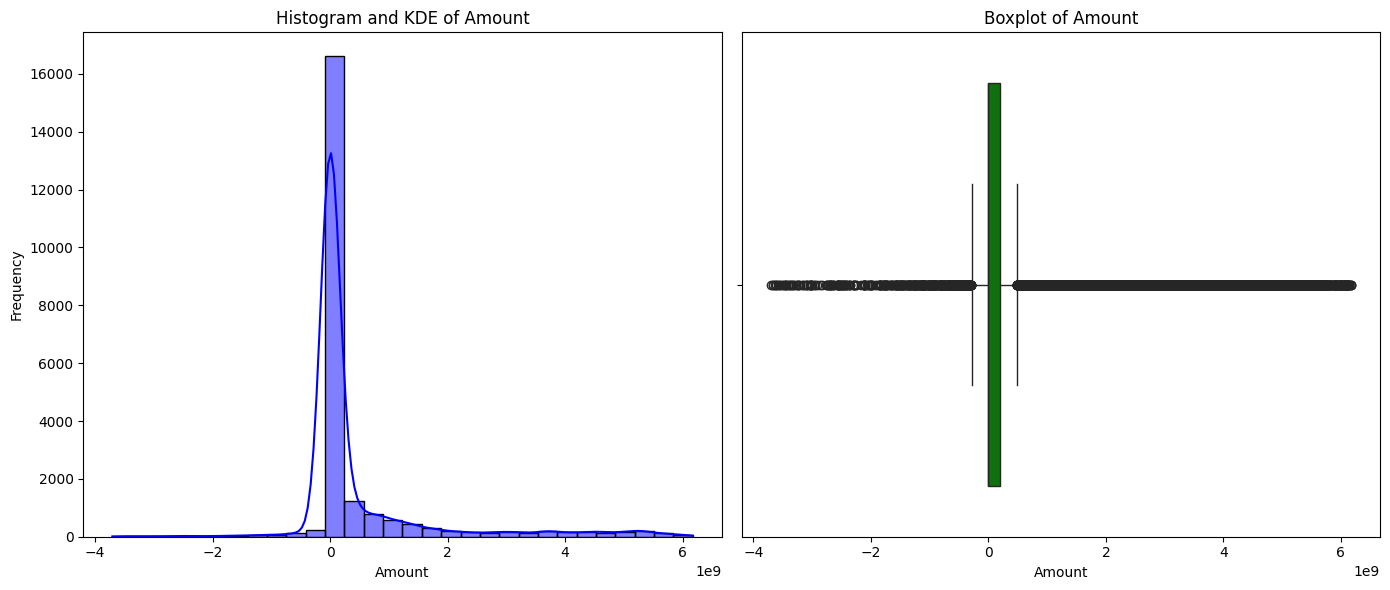

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example numeric columns
numeric_vars = ['Amount']  # Add more numeric columns if necessary

# Distribution Analysis for Numeric Variables
for num_var in numeric_vars:
    plt.figure(figsize=(14, 6))

    # Histogram with KDE for numeric variable
    plt.subplot(1, 2, 1)
    sns.histplot(df[num_var], kde=True, bins=30, color='blue')
    plt.title(f'Histogram and KDE of {num_var}')
    plt.xlabel(num_var)
    plt.ylabel('Frequency')

    # Boxplot for numeric variable
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[num_var], color='green')
    plt.title(f'Boxplot of {num_var}')
    plt.xlabel(num_var)

    plt.tight_layout()
    plt.show()


## Time-Series-Analysis

###  Data Preparation

#### Load your time series data

##### Aggregate Data by Time Period

##### Aggregate financial amounts by different time periods (e.g., monthly, quarterly, yearly) to observe trends.

In [111]:
# Developed Interactive Data Aggregation Tool

# Get all unique company names (longname) and display them
unique_companies = df['Longname'].unique()
print("Unique Companies: ")
for idx, name in enumerate(unique_companies, start=1):
    print(f"{idx}. {name}")

# Prompt the user to select a company by entering the corresponding number
company_index = int(input(f"\nEnter the number corresponding to the company you want to analyze (1-{len(unique_companies)}): "))

# Get the selected company name based on the user's input
selected_company_name = unique_companies[company_index - 1]

# Defining Aggregation Function
# Function to aggregate data based on the selected company name (longname)
def aggregate_by_company_name(company_name):
    # Filter the DataFrame for the selected company name and create a copy
    company_data = df[df['Longname'] == company_name].copy()
    
    # Ensure 'reportdate' is set as the index and convert to datetime if necessary
    company_data.loc[:, 'Reportdate'] = pd.to_datetime(company_data['Reportdate'])
    
    company_data.set_index('Reportdate', inplace=True)

    #Data Aggregation: Summarizing data in different time periods makes it easier to identify trends and anomalies that might not be apparent from raw data alone.
    
    # Aggregate by month
    monthly_amounts = company_data['Amount'].resample('ME').sum()  # 'ME' stands for Month-End frequency
    
    # Aggregate by quarter
    quarterly_amounts = company_data['Amount'].resample('QE').sum()  # 'QE' stands for Quarter-End frequency
    
    # Aggregate by year
    annual_amounts = company_data['Amount'].resample('YE').sum()  # 'YE' stands for Year-End frequency
    
    return monthly_amounts, quarterly_amounts, annual_amounts

# Call the function with the user-selected company name
monthly_amounts, quarterly_amounts, annual_amounts = aggregate_by_company_name(selected_company_name)




Unique Companies: 
1. Accenture plc
2. American International Group Inc
3. Anheuser-Busch InBev SA/NV
4. Apple Inc
5. BCE Inc
6. Banco Bradesco SA
7. Canon Inc
8. Capri Holdings Ltd
9. Carnival Corp
10. Chubb Ltd
11. Deutsche Bank AG
12. Immutep Ltd
13. LATAM Airlines Group SA
14. LG Display Co Ltd
15. NatWest Group PLC
16. Nielsen Holdings PLC
17. Nokia Corp
18. Novo-Nordisk AS
19. PT Telekomunikasi Indonesia (Persero) TBK
20. RenaissanceRe Holdings Ltd.
21. Royal Caribbean Group
22. Sanofi
23. Tata Motors Ltd
24. Telecom Italia SpA
25. Telefonica SA
26. Teva Pharmaceutical Industries Ltd
27. Ultrapetrol (Bahamas) Ltd
28. Wells Fargo & Co (New)



Enter the number corresponding to the company you want to analyze (1-28):  26


##### Visualize Time Series Data

Create plots to visualize the aggregated data to identify trends, seasonality, and anomalies.

In [113]:
df.head(60)

,Reportid,Amount,Reportdate,Reporttype,Auditorstatus,Currency,Consolidated,Longname,Status,Exchange,City,Country,Indicator,Statement
8148,1621688576,1.442549e+01,2015-11-30,Q1,U,USD,True,Accenture plc,Active,NYS,Dublin,Ireland,Operating Margin,Derived
8149,1621688576,-7.064920e+08,2015-11-30,Q1,U,USD,True,Accenture plc,Active,NYS,Dublin,Ireland,Cash From Investing,Cash Flow
8151,1621688576,1.310000e+00,2015-11-30,Q1,U,USD,True,Accenture plc,Active,NYS,Dublin,Ireland,EPS - Net Income - Basic,Income Statement
8152,1621688576,1.253842e+00,2015-11-30,Q1,U,USD,True,Accenture plc,Active,NYS,Dublin,Ireland,Current Ratio,Derived
8153,1621688576,2.774474e+01,2015-11-30,Q1,U,USD,True,Accenture plc,Active,NYS,Dublin,Ireland,Total Assets Per Share,Balance Sheet
8154,1621688576,5.420426e+01,2015-11-30,Q1,U,USD,True,Accenture plc,Active,NYS,Dublin,Ireland,Revenue Per Share,Income Statement
8155,1621688576,3.026841e+01,2015-11-30,Q1,U,USD,True,Accenture plc,Active,NYS,Dublin,Ireland,Gross Margin,Derived
8156,1621688576,6.713007e+08,2015-11-30,Q1,U,USD,True,Accenture plc,Active,NYS,Dublin,Ireland,Weighted Average Shares Outstanding - Diluted,Income Statement
8157,1621688576,5.779384e+00,2015-11-30,Q1,U,USD,True,Accenture plc,Active,NYS,Dublin,Ireland,Receivables Turnover,Derived
8158,1621688576,1.407171e+09,2015-11-30,Q1,U,USD,True,Accenture plc,Active,NYS,Dublin,Ireland,EBITDA,Income Statement


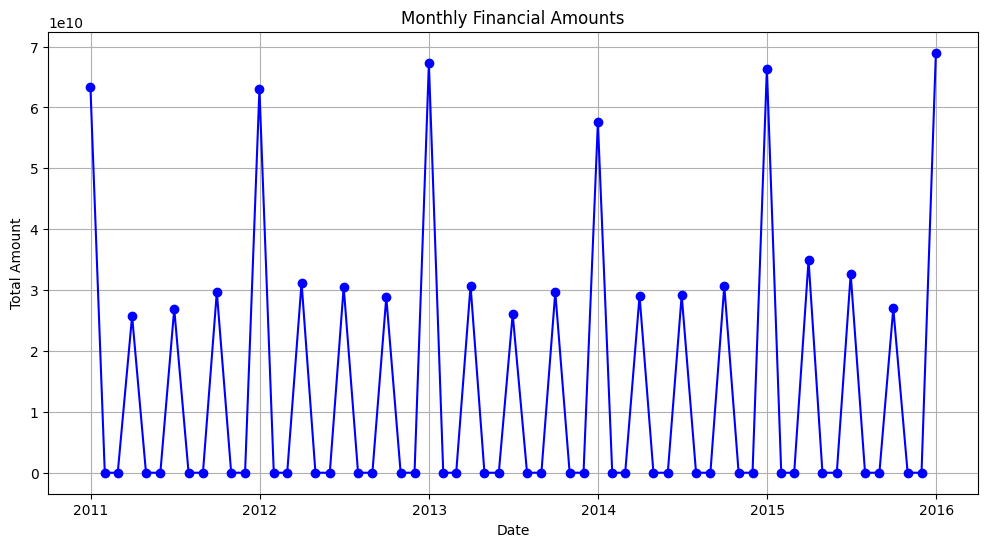

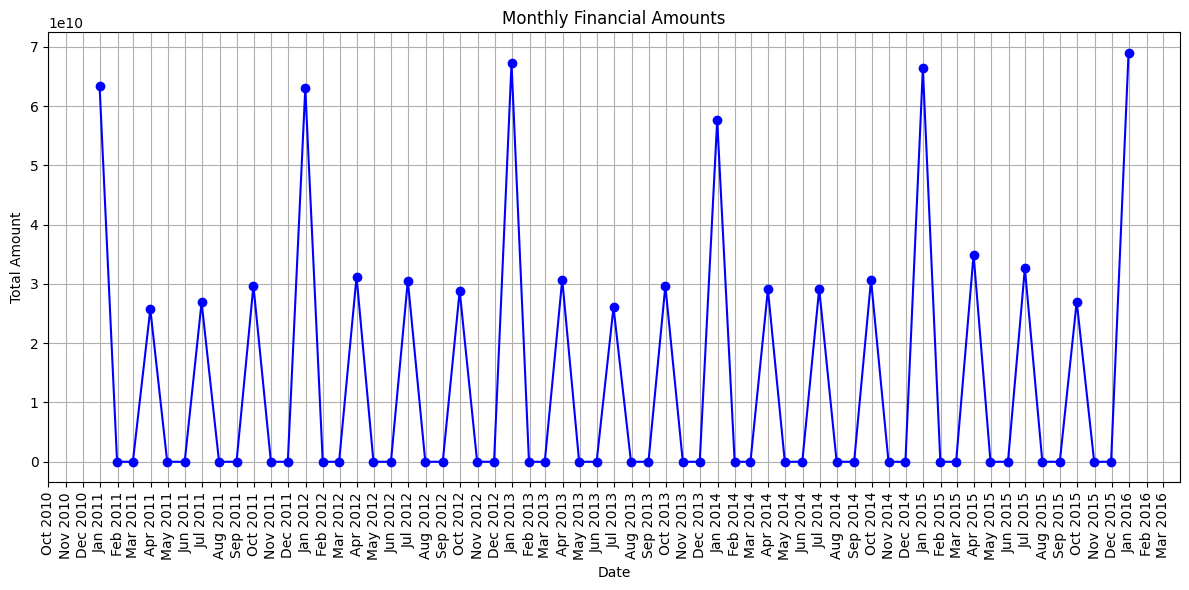

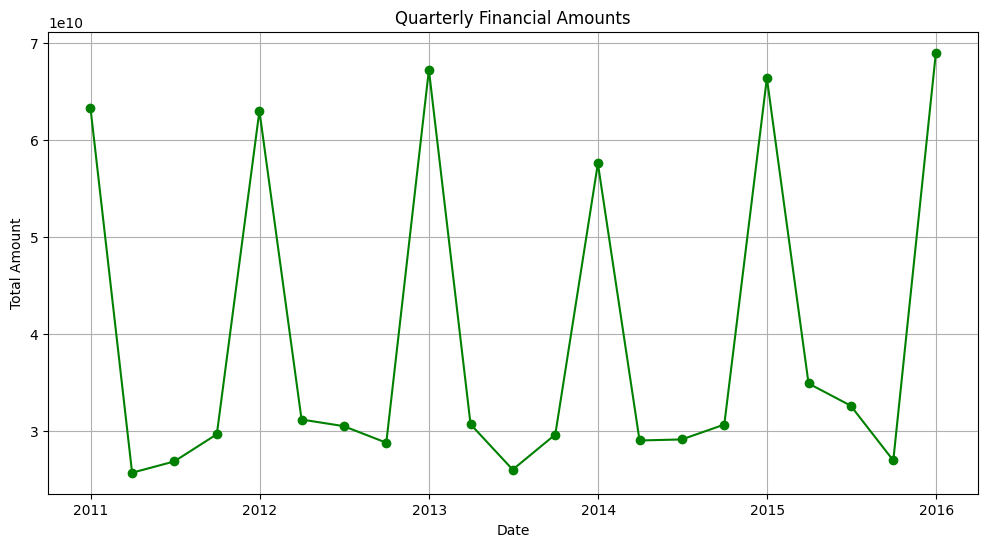

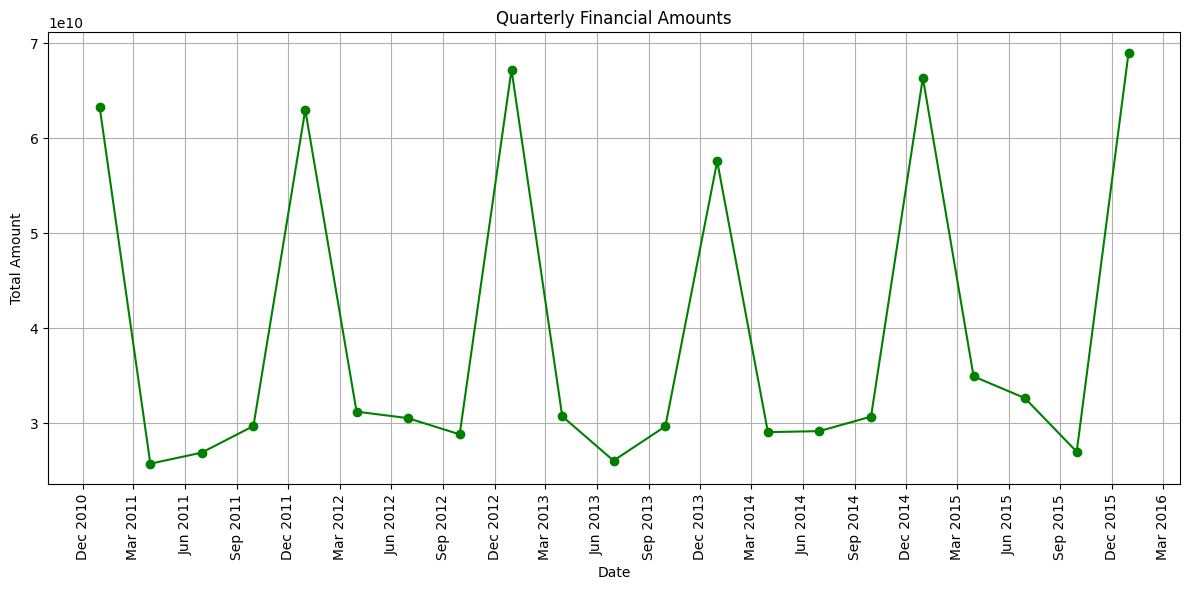

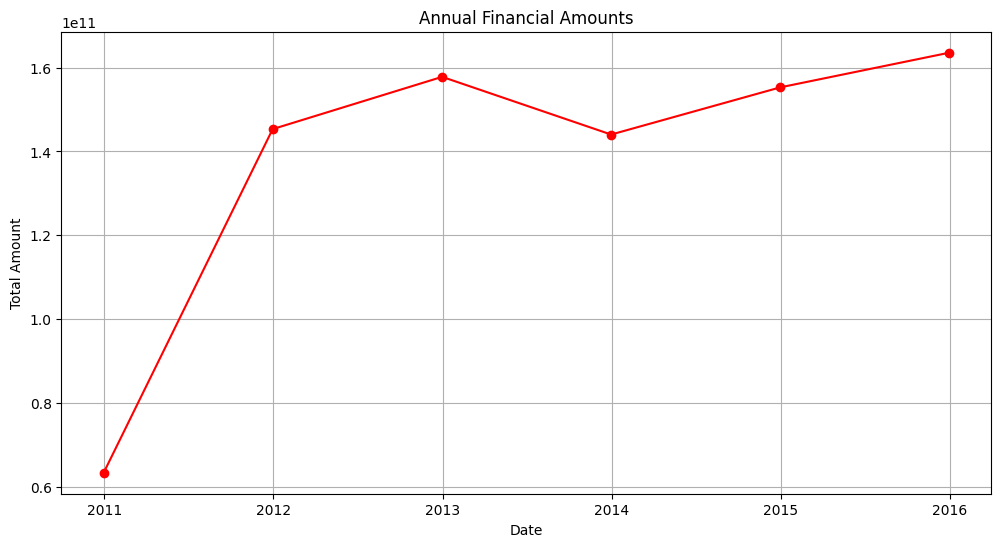

In [114]:
import matplotlib.pyplot as plt
#Use line plots to visualize the data aggregated by different periods. This helps in identifying overall trends, peaks, and troughs.

#  Visualizes financial data aggregated by month by plotting Line plots
# Information Provided:

# Trends: Helps in spotting upward or downward trends in financial amounts over months.
# Patterns: Identifies recurring patterns or seasonal effects within the monthly data.
plt.figure(figsize=(12, 6))
plt.plot(monthly_amounts.index, monthly_amounts.values, marker='o', linestyle='-', color='b')
plt.title('Monthly Financial Amounts')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.grid(True)
plt.show()

import matplotlib.dates as mdates

# Plot monthly amounts
plt.figure(figsize=(12, 6))
plt.plot(monthly_amounts.index, monthly_amounts.values, marker='o', linestyle='-', color='b')


# Formatted Monthly Financial Amounts
# Readability: Ensures that date labels are clear and easy to read, which aids in better understanding the time series data.
# Format x-axis with monthly labels
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to monthly intervals
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format the date labels as 'Month Year'

# Add title and labels
plt.title('Monthly Financial Amounts')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.grid(True)

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Plot quarterly amounts
plt.figure(figsize=(12, 6))
plt.plot(quarterly_amounts.index, quarterly_amounts.values, marker='o', linestyle='-', color='g')
plt.title('Quarterly Financial Amounts')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.grid(True)
plt.show()

import matplotlib.dates as mdates

# Plot quarterly amounts
plt.figure(figsize=(12, 6))
plt.plot(quarterly_amounts.index, quarterly_amounts.values, marker='o', linestyle='-', color='g')

# Use MonthLocator to set ticks at every third month (to represent quarters)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Set major ticks to every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format the date labels as 'Month Year'

# Add title and labels
plt.title('Quarterly Financial Amounts')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.grid(True)

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


# Plot annual amounts
plt.figure(figsize=(12, 6))
plt.plot(annual_amounts.index, annual_amounts.values, marker='o', linestyle='-', color='r')
plt.title('Annual Financial Amounts')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.grid(True)
plt.show()




#####  Decompose Time Series
Decompose the time series into trend, seasonal, and residual components to better understand underlying patterns.      
Decomposition: Separates the trend component from seasonal and residual components to clearly see the long-term movement.

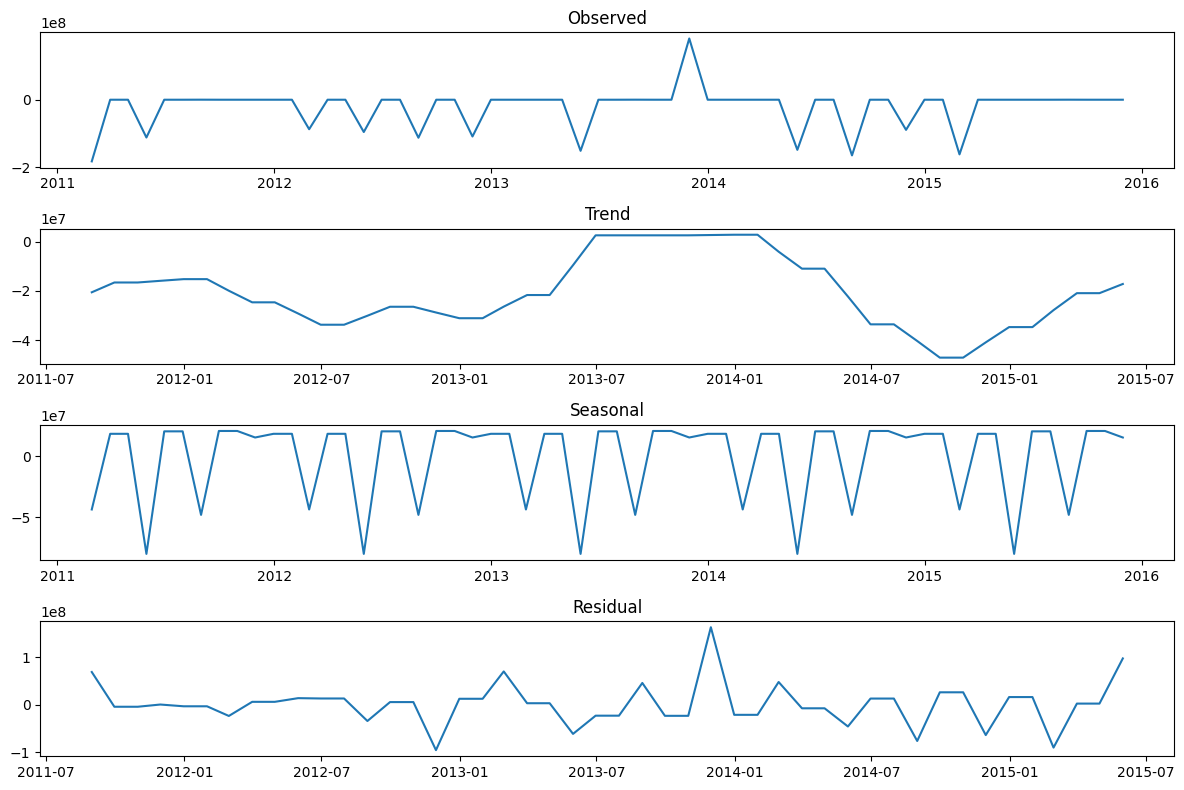

In [121]:
from statsmodels.tsa.seasonal import seasonal_decompose
# The seasonal_decompose function, is used to decompose a time series into its constituent components.
# It decomposes the time series monthly_amounts into its observed, trend, seasonal, and residual components.

# Decomposition for monthly data
decomposition = seasonal_decompose(monthly_amounts, model='additive')

# Purpose: Creates a set of plots to visualize the different components of the decomposed time series.
# Components:
# Observed: The original time series data.
# Trend: The long-term movement in the data.
# Seasonal: The repeating short-term cycle or seasonal variation in the data.
# Residual: The remaining noise or irregular component after removing the trend and seasonal effects.


# Plot decomposition
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label='Observed')
plt.title('Observed')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend')
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.title('Seasonal')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual')
plt.title('Residual')
plt.tight_layout()
plt.show()


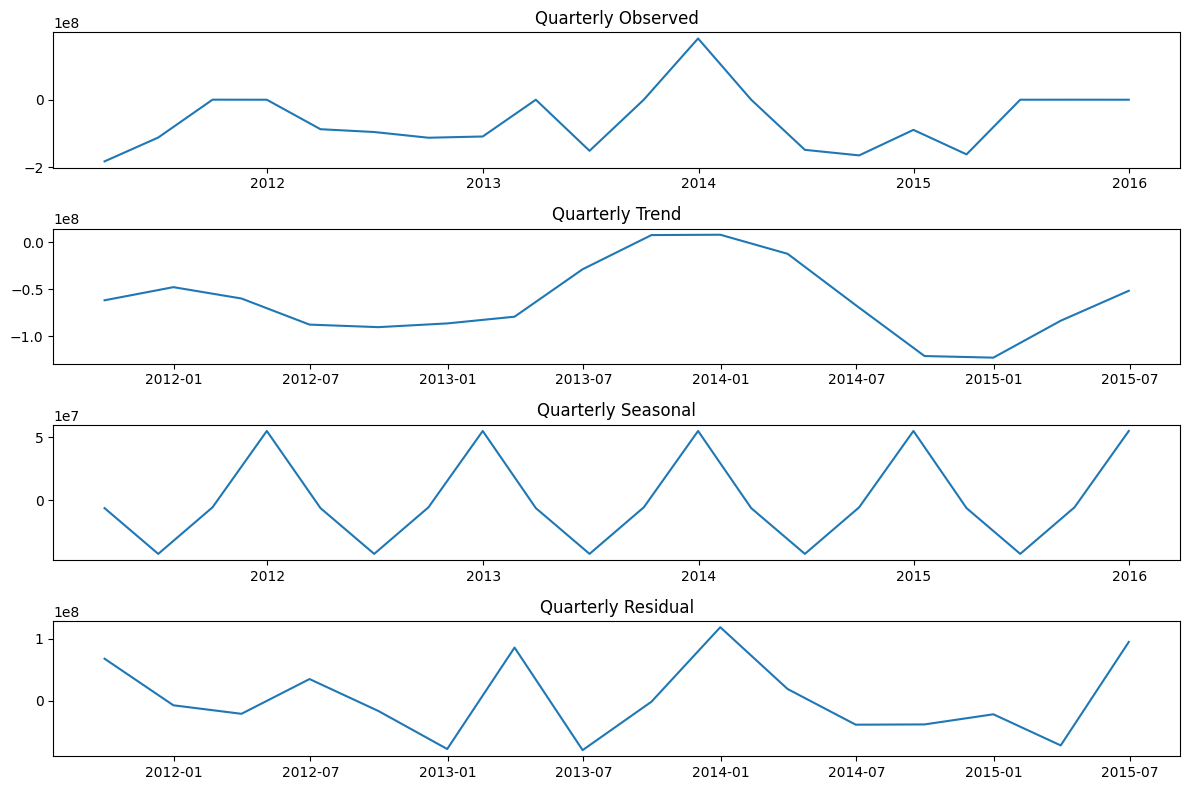

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose quarterly data
decomposition_quarterly = seasonal_decompose(quarterly_amounts, model='additive')

# Plot decomposition for quarterly data
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(decomposition_quarterly.observed, label='Observed')
plt.title('Quarterly Observed')

plt.subplot(4, 1, 2)
plt.plot(decomposition_quarterly.trend, label='Trend')
plt.title('Quarterly Trend')

plt.subplot(4, 1, 3)
plt.plot(decomposition_quarterly.seasonal, label='Seasonal')
plt.title('Quarterly Seasonal')

plt.subplot(4, 1, 4)
plt.plot(decomposition_quarterly.resid, label='Residual')
plt.title('Quarterly Residual')

plt.tight_layout()
plt.show()


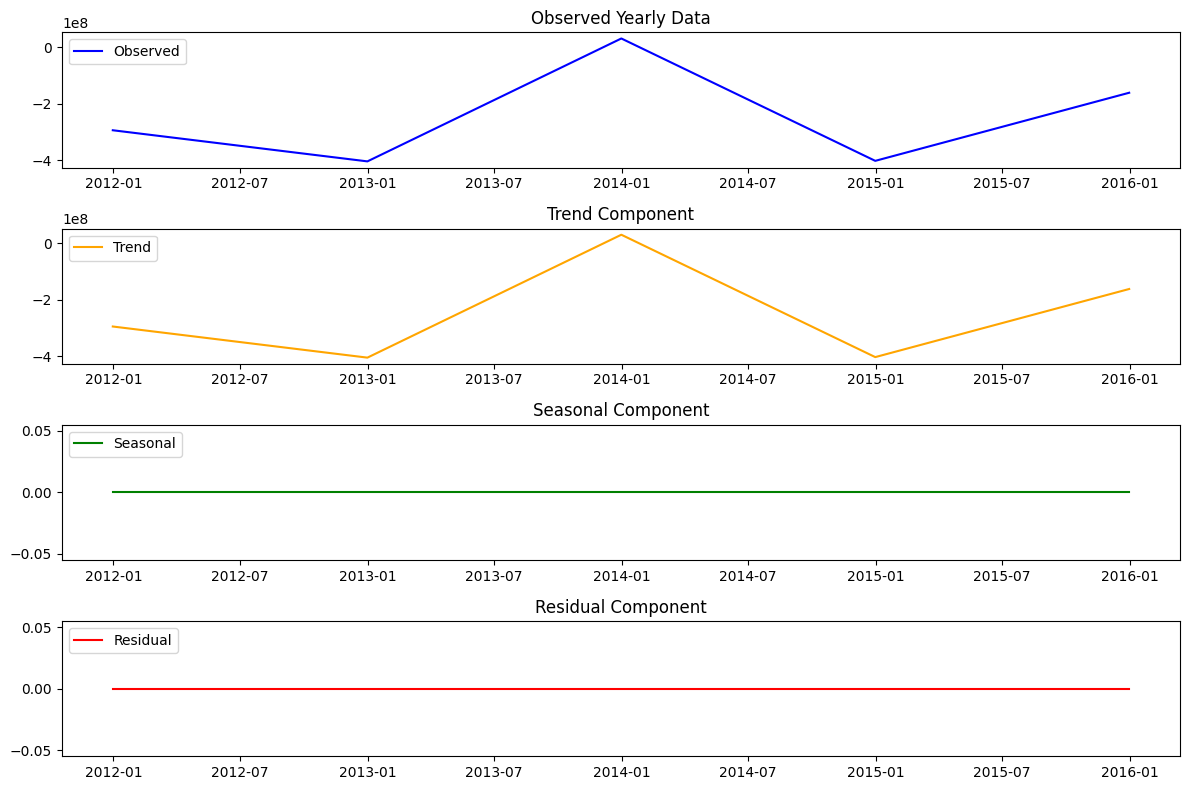

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the yearly data
decomposition_yearly = seasonal_decompose(annual_amounts, model='additive')

# Plot decomposition for yearly data
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(decomposition_yearly.observed, label='Observed', color='blue')
plt.title('Observed Yearly Data')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(decomposition_yearly.trend, label='Trend', color='orange')
plt.title('Trend Component')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(decomposition_yearly.seasonal, label='Seasonal', color='green')
plt.title('Seasonal Component')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(decomposition_yearly.resid, label='Residual', color='red')
plt.title('Residual Component')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


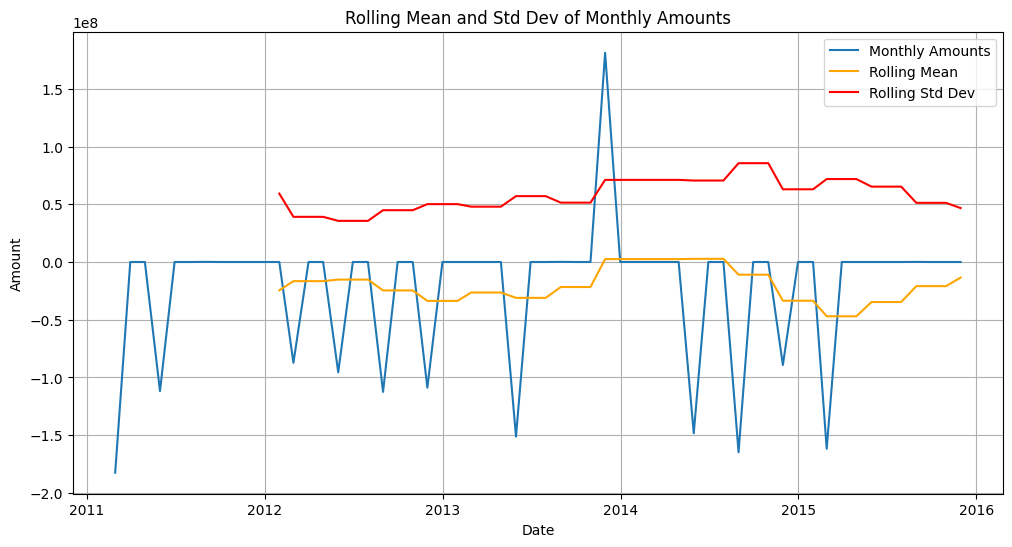

In [129]:
# Rolling statistics

# Purpose: Calculates rolling (or moving) statistics over a specified window size. In this case, a window of 12 periods is used.
# Parameters:
# window=12: Specifies the number of periods to include in each rolling window. Here, it's set to 12 periods, which typically represents a year if the data is monthly.
# .mean(): Computes the rolling mean for each window.
# .std(): Computes the rolling standard deviation for each window.

rolling_mean = monthly_amounts.rolling(window=12).mean()
rolling_std = monthly_amounts.rolling(window=12).std()

# Plot rolling statistics
plt.figure(figsize=(12, 6))
plt.plot(monthly_amounts, label='Monthly Amounts')
plt.plot(rolling_mean, label='Rolling Mean', color='orange')
plt.plot(rolling_std, label='Rolling Std Dev', color='red')
plt.title('Rolling Mean and Std Dev of Monthly Amounts')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.show()


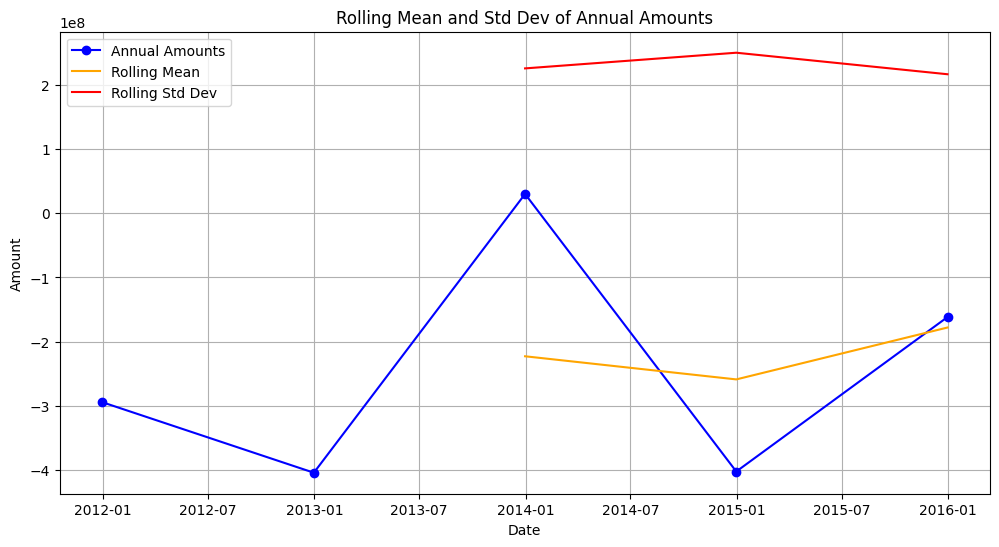

In [130]:
# Calculate rolling statistics
rolling_mean_yearly = annual_amounts.rolling(window=3).mean()  # 3-year window for rolling mean
rolling_std_yearly = annual_amounts.rolling(window=3).std()    # 3-year window for rolling std dev

# Plot rolling statistics
plt.figure(figsize=(12, 6))
plt.plot(annual_amounts, label='Annual Amounts', marker='o', linestyle='-', color='b')
plt.plot(rolling_mean_yearly, label='Rolling Mean', color='orange')
plt.plot(rolling_std_yearly, label='Rolling Std Dev', color='red')
plt.title('Rolling Mean and Std Dev of Annual Amounts')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.show()

##### Identify Anomalies
Detect anomalies or outliers in the time series data which may indicate significant events or errors.

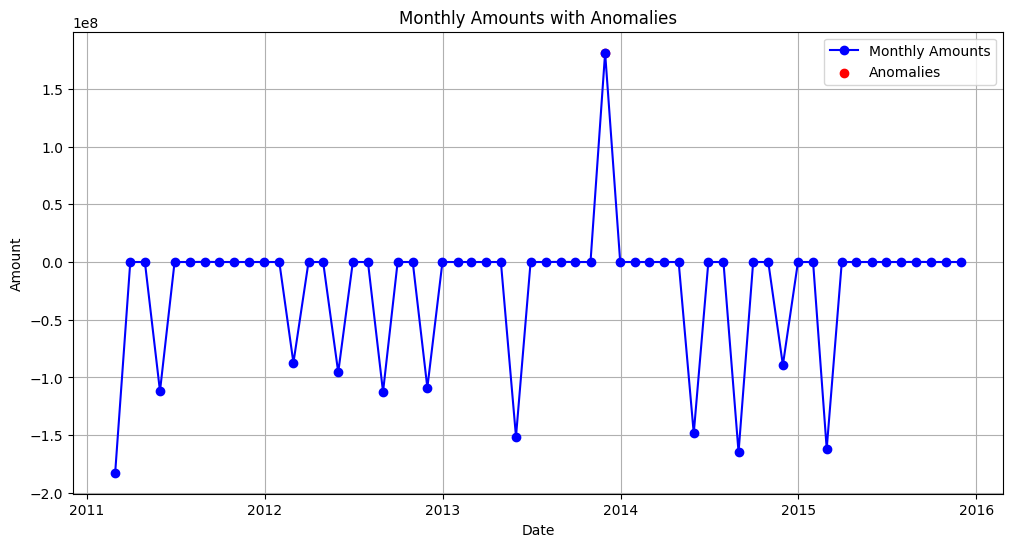

In [131]:
# Plot with anomalies
plt.figure(figsize=(12, 6))
plt.plot(monthly_amounts.index, monthly_amounts.values, marker='o', linestyle='-', color='b', label='Monthly Amounts')

# Highlight anomalies
anomalies = monthly_amounts[monthly_amounts > (rolling_mean + 2 * rolling_std)]
plt.scatter(anomalies.index, anomalies.values, color='red', label='Anomalies')

plt.title('Monthly Amounts with Anomalies')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.show()


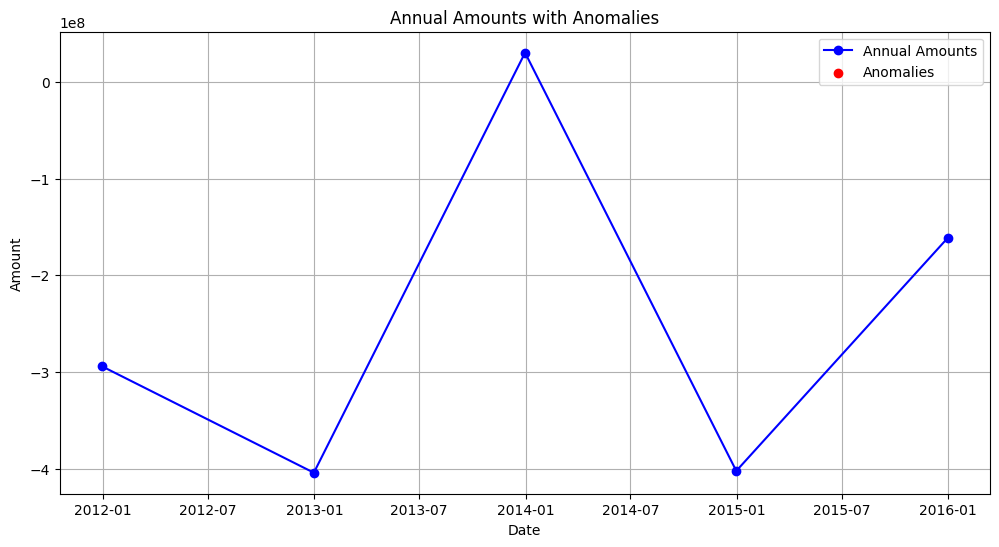

In [132]:
# Identify and plot anomalies
anomalies_yearly = annual_amounts[annual_amounts > (rolling_mean_yearly + 2 * rolling_std_yearly)]

# Plot with anomalies
plt.figure(figsize=(12, 6))
plt.plot(annual_amounts.index, annual_amounts.values, marker='o', linestyle='-', color='b', label='Annual Amounts')
plt.scatter(anomalies_yearly.index, anomalies_yearly.values, color='red', label='Anomalies')
plt.title('Annual Amounts with Anomalies')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.show()